# 0.0. Imports

In [1]:
import inflection
import pickle

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express    as px

from scipy                   import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics         import classification_report, confusion_matrix
from imblearn.over_sampling  import SMOTENC

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

sns.set_palette('RdBu_r')
sns.set_style('darkgrid')

## 0.1. Helper Functions

In [3]:
def numeric_statistics( df ):
    dic = {
        "type": df.dtypes.values,
        "Not_null": df.count().values,
        "Null": df.shape[0] - df.count().values,
        "Null%": 100 * (df.shape[0] - df.count().values)/df.shape[0],
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

def cramer_v( x, y ):
    
    cm   = pd.crosstab( x, y ).values
    n    = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr    = k - (k-1)**2/(n-1)
    rcorr    = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1,rcorr-1) ) )

def model_report( model_name, y_test, pred ):
    
    print( "-------------{}-------------" .format( model_name), '\n')
    print( pd.crosstab(y_test, pred, rownames=['Real'], colnames=['Prediction'], margins=True), '\n' )
    print( classification_report( y_test, pred ) )
    
def cross_validation( md_name, md, k, xtraining, ytraining ):
    

    kfold = KFold( n_splits=k, shuffle=True, random_state=1 )

    model = md
    
    accuracy_list = cross_val_score( model, xtraining, ytraining, cv=kfold, scoring='accuracy' )
    
    balanced_ac = cross_val_score( model, xtraining, ytraining, cv=kfold, scoring='balanced_accuracy' ).mean()
    accuracy    = cross_val_score( model, xtraining, ytraining, cv=kfold, scoring='accuracy' ).mean()
    
    balanced_ac_cv = str( round( (cross_val_score( model, xtraining, ytraining, cv=kfold, scoring='balanced_accuracy' ).std()) / balanced_ac, 3) * 100 )
    accuracy_cv    = str( round( (cross_val_score( model, xtraining, ytraining, cv=kfold, scoring='accuracy' ).std()) / accuracy , 3) * 100 )
    
    return (pd.DataFrame( {"model": md_name,
                         "accuracy": accuracy,
                         "balanced_accuracy": balanced_ac,
                         "accuracy_cv": accuracy_cv+" %",
                         "balanced_ac_cv": balanced_ac_cv+" %"}, index=[0] ), accuracy_list)

# 1.0. Load And Data Description

In [4]:
# Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.
df1 = pd.read_csv('data/census.csv')

In [5]:
df1.head()

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loos,hour-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1.1. Data Dimension

In [6]:
print(" Number of Rows:    {}" .format(df1.shape[0] ) )
print(" Number of Columns: {}" .format(df1.shape[1] ) )

 Number of Rows:    32561
 Number of Columns: 15


## 1.2. Data Types

In [7]:
df1.dtypes

age                int64
workclass         object
final-weight       int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loos       int64
hour-per-week      int64
native-country    object
income            object
dtype: object

## 1.3 Check NA

In [8]:
df1.isnull().sum()

age               0
workclass         0
final-weight      0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loos      0
hour-per-week     0
native-country    0
income            0
dtype: int64

## 1.4. Descriptive Statistics

### 1.4.1 Numerical Variables

In [10]:
aux = df1.select_dtypes( include = ['int64','float64'] )

In [16]:
numeric_statistics( aux )

,type,Not_null,Null,Null%,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
age,int64,32561,0,0.0,73,38.581647,37.0,13.640433,17,90,73,0.558743,-0.166127
final-weight,int64,32561,0,0.0,21648,189778.366512,178356.0,105549.977697,12285,1484705,1472420,1.446980,6.218811
education-num,int64,32561,0,0.0,16,10.080679,10.0,2.572720,1,16,15,-0.311676,0.623444
capital-gain,int64,32561,0,0.0,119,1077.648844,0.0,7385.292085,0,99999,99999,11.953848,154.799438
capital-loos,int64,32561,0,0.0,92,87.303830,0.0,402.960219,0,4356,4356,4.594629,20.376802
hour-per-week,int64,32561,0,0.0,94,40.437456,40.0,12.347429,1,99,98,0.227643,2.916687


### 1.4.2 Categorical Variables

In [11]:
aux = df1.select_dtypes( include='object' )

In [12]:
aux.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


## 1.5. Rename Columns

In [13]:
old_columns = df1.columns

snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase, old_columns ) )

df1.columns = new_cols

# 2.0. Problem Hypothesis

In [14]:
df2 = df1.copy()

Here I'm going to list some business hypotesis to be validated or not in the EDA step

- H1 - The older, the higher the level of education.
- H2 - The mean age of people that work in Private class is higher than State-gov.
- H3 - The mean age of people that has "Bachelor's level" of education is higher than "some-college".
- H4 - The mean age of people that works 30 hours or more is lower than 30 years old.
- H5 - The most of people that work 30 hours or more are in a level of education higher than Bachelors.
- H6 - People that has a higher level of education work less.

# 3.0. EDA

In [15]:
df3 = df2.copy()

In [16]:
df3.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loos,hour_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 3.1. Univariate Analysis

### 3.1.1. Response Variable

In [17]:
df3['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

<AxesSubplot:xlabel='income', ylabel='count'>

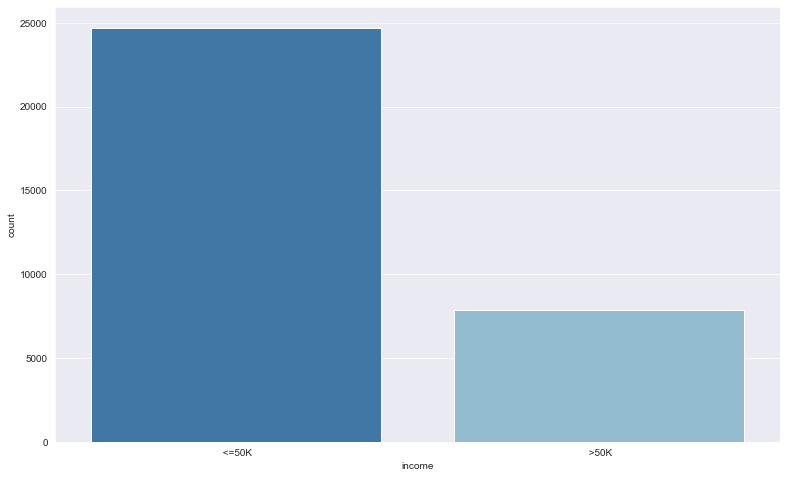

In [18]:
sns.countplot( data=df3, x='income' )

### 3.1.1. Numerical Variable

These variables **capital_loos** and **capital gain** provide no information that might make the prediction better. Because it has no variation, furthermore they are totally unbalanced.

In [19]:
pc01 = str( df1[df1['capital_loos'] < 500]['capital_loos'].count() / df1.shape[0] ) + ' %'
print( 'Percentage of concentrated data under 500: {}' .format( pc01 ) )

Percentage of concentrated data under 500: 0.953686926077209 %


In [20]:
pc02 = str( df1[df1['capital_gain'] < 10000]['capital_gain'].count() / df1.shape[0] ) + ' %'
print( 'Percentage of concentrated data under 10000: {}' .format( pc02 ) )

Percentage of concentrated data under 10000: 0.9763520776388932 %


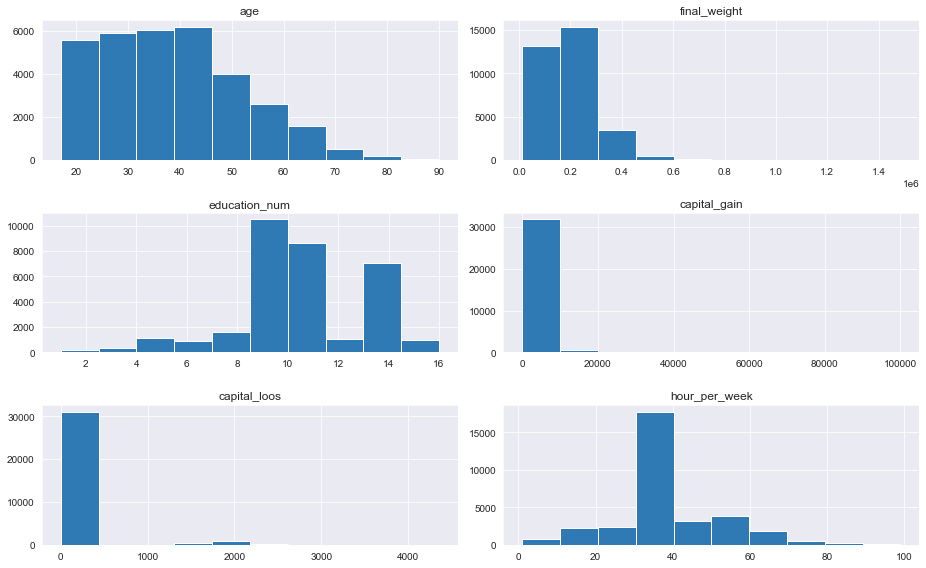

In [21]:
df3.hist()
plt.tight_layout()

### 3.1.1. Categorical Variable

In [22]:
aux = df1.select_dtypes( include='object')
aux.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


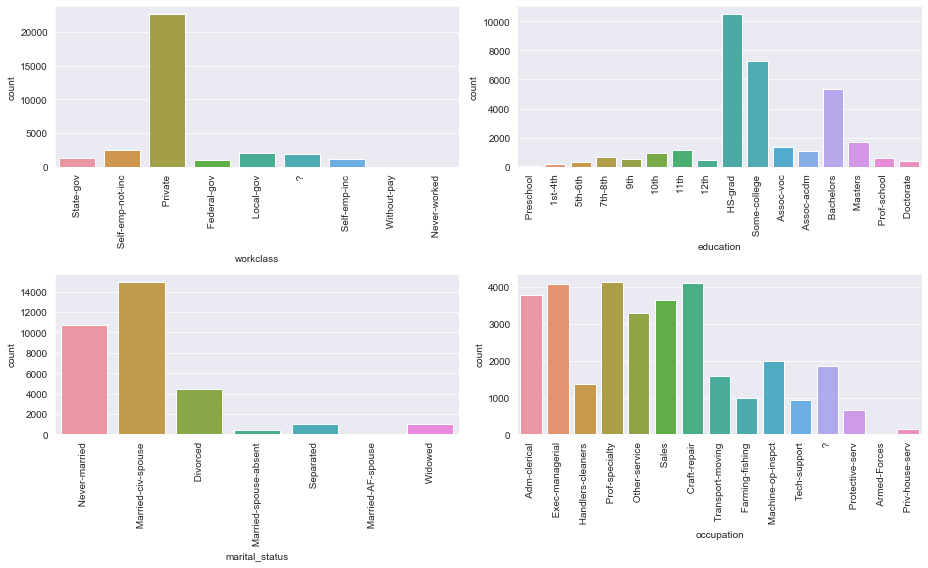

In [23]:
plt.subplot( 2, 2, 1)
sns.countplot( data=aux, x='workclass' )
plt.xticks( rotation=90 )
plt.tight_layout()

plt.subplot( 2, 2, 2 )
list01 = df3['education_num'].value_counts().index
list02 = df3['education'].value_counts().index

dic = pd.Series( list02, list01 )
dic = dic.sort_index()

sns.countplot( data=aux, x='education', order=dic)
plt.xticks( rotation=90 )
plt.tight_layout()

plt.subplot( 2, 2, 3 )
sns.countplot( data=aux, x='marital_status' )
plt.xticks( rotation=90 )
plt.tight_layout()

plt.subplot( 2, 2, 4 )
sns.countplot( data=aux, x='occupation' )
plt.xticks( rotation=90 )
plt.tight_layout()

Here The variable **native_contry** is totally unbalanced taking almost 90% of the dataset

In [24]:
pc03 = str( aux[aux['native_country'] == ' United-States']['native_country'].count() / df1.shape[0] ) + ' %'
print( 'Percentage of concentrated data = United States: {}' .format( pc03 ) )

Percentage of concentrated data = United States: 0.895857006848684 %


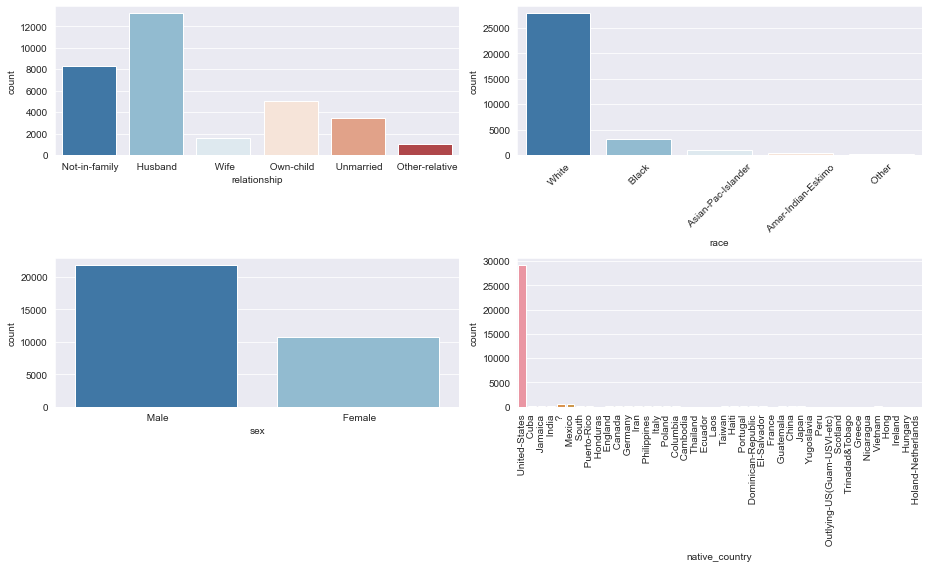

In [25]:
plt.subplot( 2, 2, 1 )
sns.countplot( data=aux, x='relationship' )
plt.tight_layout()

plt.subplot( 2, 2, 2 )
sns.countplot( data=aux, x='race' )
plt.xticks( rotation=45 )
plt.tight_layout()

plt.subplot( 2, 2, 3 )
sns.countplot( data=aux, x='sex' )
plt.tight_layout()

plt.subplot( 2, 2, 4 )
sns.countplot( data=aux, x='native_country' )
plt.xticks( rotation=90 )
plt.tight_layout()

## 3.2. Bivariate Analysis

### H1. The older, the higher the level of education.
**FALSE**

In [97]:
df_aux = df3[['age','education_num']].groupby( 'education_num' ).mean().reset_index()
df_aux.sort_values( 'age', ascending=False ).head( 5 )

,education_num,age
3,4,48.445820
15,16,47.702179
1,2,46.142857
14,15,44.746528
13,14,44.049913


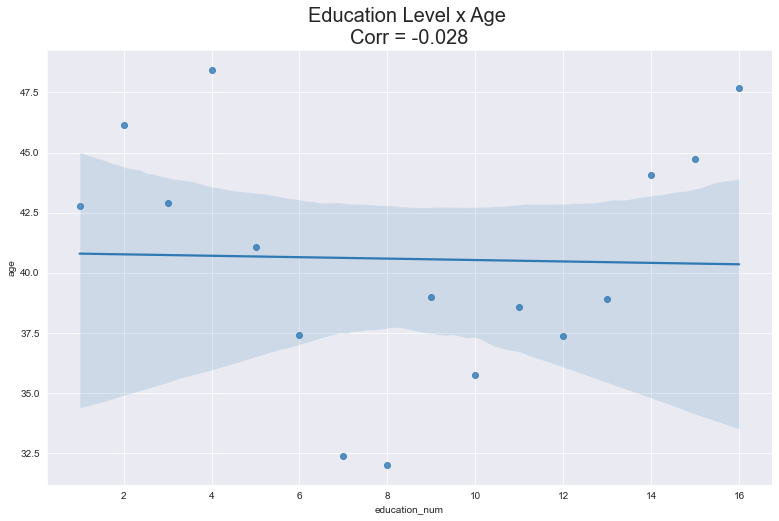

In [98]:
corr = df_aux.corr()['age'][0]

sns.regplot( data=df_aux, x='education_num', y='age' )
plt.title( 'Education Level x Age \nCorr = {}' .format( round( corr, 3) ), fontsize=20 );

### H2. The mean age of people that work in Private class is higher than State-gov.
**FALSE**

In [107]:
df_aux = df3[['age','workclass']].groupby( 'workclass' ).mean().reset_index()
df_aux01 = df_aux[ (df_aux['workclass'] == ' State-gov') | (df_aux['workclass'] == ' Private') ]
df_aux01

,workclass,age
4,Private,36.797585
7,State-gov,39.436055


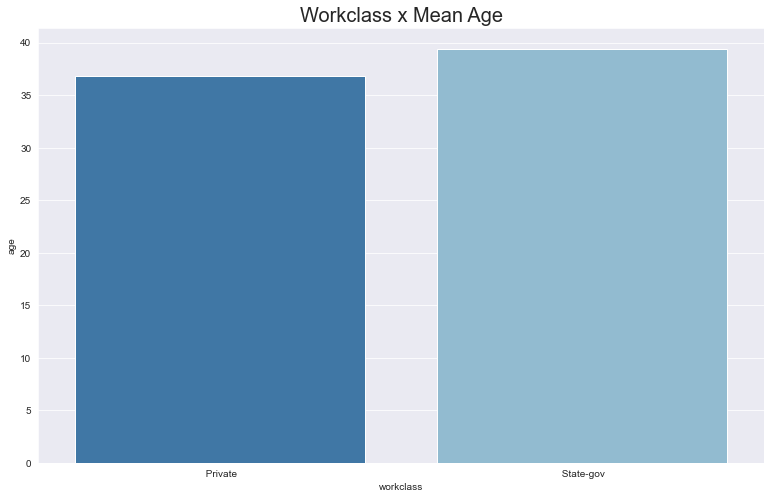

In [108]:
sns.barplot( data=df_aux01, x='workclass', y='age' )
plt.title( 'Workclass x Mean Age', fontsize=20 );

### H3. The mean age of people that has "Bachelor's level" of education is higher than "some-college".
**TRUE**

In [110]:
df_aux = df3[['age','education']].groupby( 'education' ).mean().reset_index()
df_aux = df_aux[ ( df_aux['education'] == ' Bachelors' ) | ( df_aux['education'] == ' Some-college' ) ]
df_aux

,education,age
9,Bachelors,38.904949
15,Some-college,35.756275


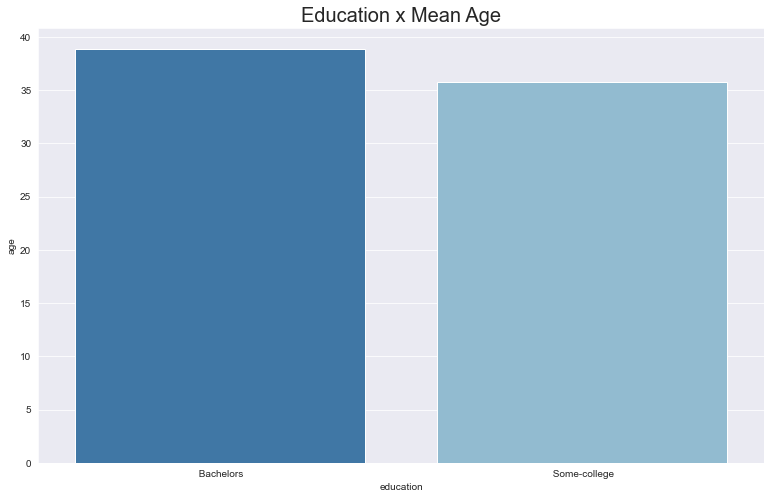

In [111]:
sns.barplot( data=df_aux, x='education', y='age' )
plt.title( 'Education x Mean Age', fontsize=20 );

### H4. The mean age of people that works 30 hours or more is lower than 30 years old.
**TRUE**

In [121]:
df_aux = df3.copy()
df_aux['more_than_30'] = df_aux['hour_per_week'].apply( lambda x: '>=30' if x>30 else '<30' )

df_aux = df_aux[['age','more_than_30']].groupby( 'more_than_30' ).mean().reset_index()
df_aux

,more_than_30,age
0,<30,36.070734
1,>=30,39.063772


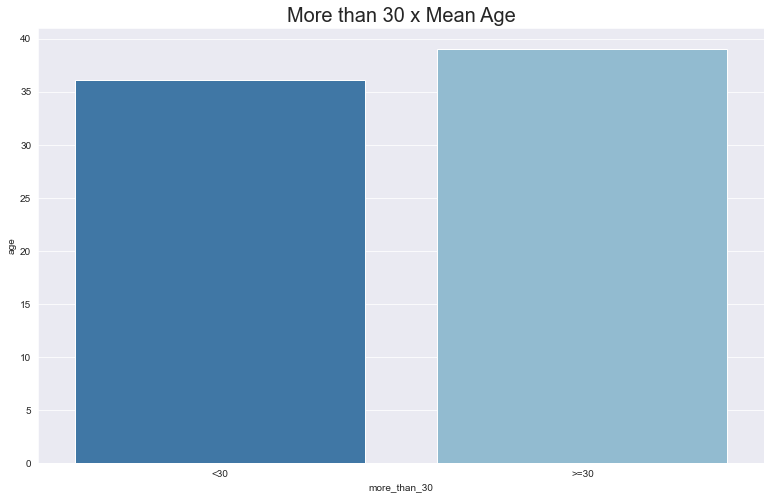

In [122]:
sns.barplot( data=df_aux, x='more_than_30', y='age' )
plt.title( 'More than 30 x Mean Age', fontsize=20 );

### H5. The most of people that work 30 hours or more are in a level of education higher than Bachelors.
**FALSE** 

In [128]:
df_aux = df3.copy()
df_aux['more_than_30'] = df_aux['hour_per_week'].apply( lambda x: '>=30' if x>30 else '<30' )
df_aux['bach_or_not']  = df_aux['education'].apply( lambda x: 'Bachelors' if x == ' Bachelors' else 'not_Bachelors' )
df_aux = df_aux[['more_than_30','bach_or_not']]
df_aux.head()

,more_than_30,bach_or_not
0,>=30,Bachelors
1,<30,Bachelors
2,>=30,not_Bachelors
3,>=30,not_Bachelors
4,>=30,Bachelors


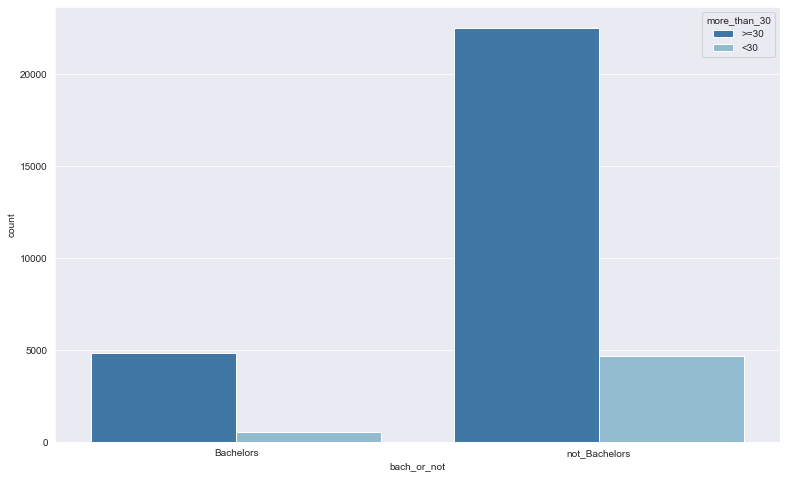

In [131]:
sns.countplot( data=df_aux, x='bach_or_not', hue='more_than_30' );

### H6. People that has a higher level of education work less
**FALSE**

In [135]:
df_aux = df3[['education_num','hour_per_week']]

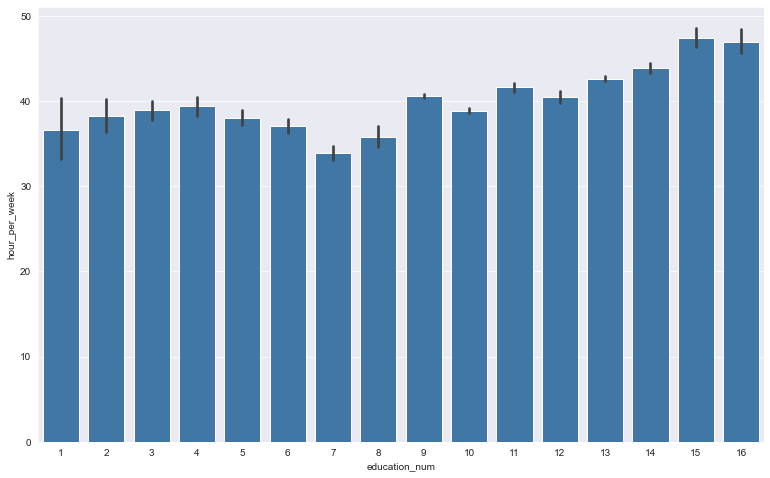

In [154]:
sns.barplot( data=df_aux, x='education_num', y='hour_per_week', color=sns.color_palette( 'RdBu_r' )[0] );

### A table of The age distribution related with each workclass.
To see the visualization with plotly, access https://nbviewer.jupyter.org/ and load the link of this github page

In [158]:
graph = px.treemap( df3, path=['workclass','age'], color_discrete_sequence=px.colors.qualitative.T10)
graph.show()

## 3.3. Multiivariate Analysis

### 3.3.1 Numerical Variables

In [29]:
aux = df3.select_dtypes( include='int64' )

Here is shown the correlation among the Numerical Variables. It's interesting to notice that no variable has a strong linear correlation to each other.

<AxesSubplot:>

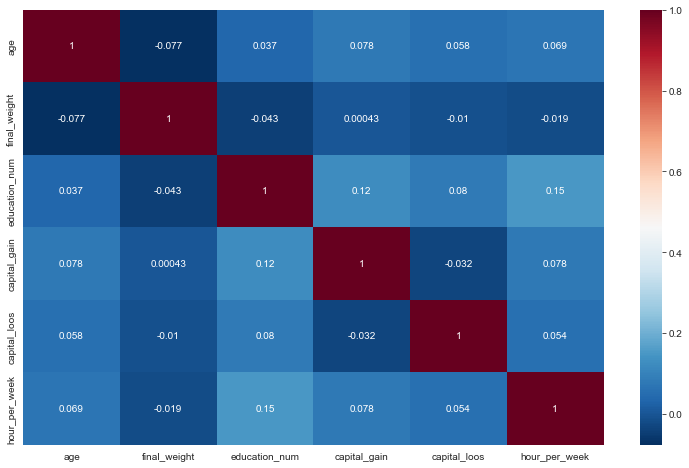

In [30]:
corr = aux.corr( method='pearson' )
sns.heatmap( corr, annot=True, cmap='RdBu_r')

### 3.3.1 Categorical Variables

In [31]:
aux = df3.select_dtypes( include='object' )

In [32]:
aux.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [33]:
lista0 = []
lista1 = []
lista2 = []
lista3 = []
lista4 = []
lista5 = []
lista6 = []
lista7 = []
lista8 = []

for i in range(9):
    for j in range(9):
        a = cramer_v( aux.iloc[:,i], aux.iloc[:,j] )
        
        if i==0:
            lista0.append(a)
            
        elif i==1:
            lista1.append(a)
            
        elif i==2:
            lista2.append(a)
            
        elif i==3:
            lista3.append(a)
            
        elif i==4:
            lista4.append(a)
            
        elif i==5:
            lista5.append(a)
            
        elif i==6:
            lista6.append(a)
            
        elif i==7:
            lista7.append(a)
            
        else:
            lista8.append(a)

<AxesSubplot:>

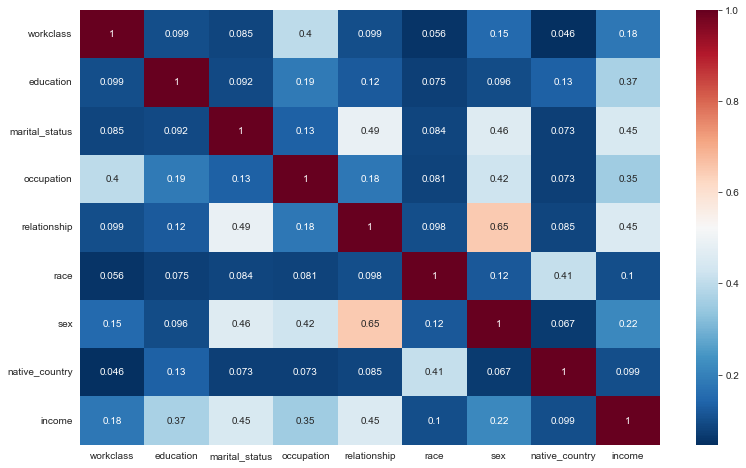

In [34]:
df=pd.DataFrame( lista0 )

for i in range(1,9):
    if i==1:
        df['1'] = lista1
        
    elif i==2:
        df['2'] = lista2
        
    elif i==3:
        df['3'] = lista3
        
    elif i==4:
        df['4'] = lista4
    
    elif i==5:
        df['5'] = lista5
    
    elif i==6:
        df['6'] = lista6
        
    elif i==7:
        df['7'] = lista7
        
    else:
        df['8'] = lista8
        
df.columns = aux.columns
df = df.set_index( aux.columns )
sns.heatmap( df, annot=True, cmap='RdBu_r')

# 4.0 Filtering Variables

In [35]:
df4 = df3.copy()

I've decided to drop these columns:

- **education**: Because already exist a column encoded to this column which is **education_num**

- **capital_gain**, **capital_loos** and **native_country** for its unbalanced structure.

In [36]:
df4 = df4[df4['native_country'] == ' United-States' ]

df4 = df4.drop( ['education', 'capital_gain', 'capital_loos', 'native_country'], axis=1 )

# 5.0. Data Preparation

## 5.1. Rescaling

In [37]:
df5 = df4.copy()
aux = df5.select_dtypes( include='int64' )

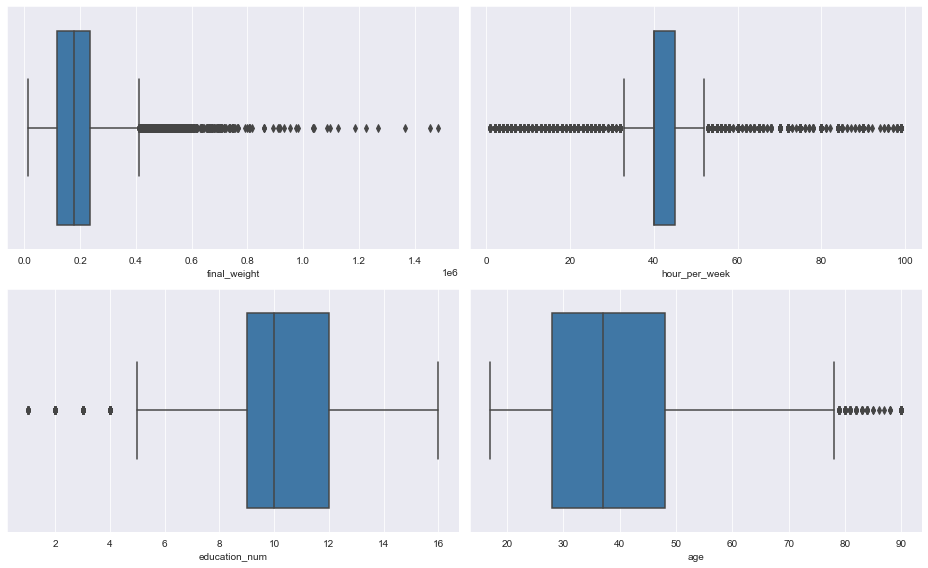

In [38]:
plt.subplot( 2, 2, 1 )
sns.boxplot( data=aux, x='final_weight')
plt.tight_layout()

plt.subplot( 2, 2, 2 )
sns.boxplot( data=aux, x='hour_per_week')
plt.tight_layout()

plt.subplot( 2, 2, 3 )
sns.boxplot( data=aux, x='education_num')
plt.tight_layout()

plt.subplot( 2, 2, 4 )
sns.boxplot( data=aux, x='age')
plt.tight_layout()

In [39]:
mms = MinMaxScaler()
rs  = RobustScaler()

# MinMaxScaler
df5['age']           = mms.fit_transform( df5[['age']].values )

df5['education_num'] = mms.fit_transform( df5[['education_num']].values )

# RobustScaler
df5['final_weight']  = rs.fit_transform( df5[['final_weight']].values )

df5['hour_per_week'] = rs.fit_transform( df5[['hour_per_week']].values )

## 5.2. Encoder

In [40]:
le = LabelEncoder()

####### Label Encoding #########

# income
df5['income'] = df5['income'].map( {" <=50K":1, " >50K":0} )

# sex
df5['sex']    = le.fit_transform( df5['sex'] )

####### OneHotEncoding #########

# relationship
df5 = pd.get_dummies( df5, columns=['relationship'], prefix=['relationship'] )

####### Target Encoding #########

# occupation
df5['occupation']     = df5[['occupation','income']].groupby('occupation').transform("mean")

# workclass
df5['workclass']      = df5[['workclass','income']].groupby('workclass').transform("mean")

# marital_status
df5['marital_status'] = df5[['marital_status','income']].groupby('marital_status').transform("mean")

# race
df5['race']           = df5[['race','income']].groupby('race').transform("mean")

In [41]:
df5.head()

,age,workclass,final_weight,education_num,marital_status,occupation,race,sex,hour_per_week,income,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife
0,0.301370,0.730579,-0.839067,0.800000,0.953231,0.867208,0.738340,1,0.0,1,0,1,0,0,0,0
1,0.452055,0.715089,-0.790058,0.800000,0.542415,0.513253,0.738340,1,-5.4,1,1,0,0,0,0,0
2,0.287671,0.774472,0.329118,0.533333,0.895483,0.938604,0.738340,1,0.0,1,0,1,0,0,0,0
3,0.493151,0.774472,0.490438,0.400000,0.542415,0.938604,0.876059,1,0.0,1,1,0,0,0,0,0
5,0.273973,0.774472,0.912120,0.866667,0.542415,0.513253,0.738340,0,0.0,1,0,0,0,0,0,1


## 5.3. Unbalanced Data

In [42]:
x = df5.drop( 'income', axis=1 )
y = df5['income']

The minority class has almost 25% of the dataset size. It might be considered as a mild unbalanced class. But is necessary to make some adjust

In [43]:
y.value_counts( normalize=True )

1    0.754165
0    0.245835
Name: income, dtype: float64

**SMOTE**

> Synthetic Minority Oversampling Technique is an oversampling technique but SMOTE working differently than your typical oversampling. In a classic oversampling technique, the minority data is duplicated from the minority data population. While it increases the number of data, it does not give any new information or variation to the machine learning model.SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set. Synthetic data would then made between the random data and the randomly selected k-nearest neighbor. Let me show you the example below. The procedure is repeated enough times until the minority class has the same proportion as the majority class. (https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5)

There is a problem with using the **SMOTE** technic from a raw way. Because SMOTE treats with continuous data. And then, it might bring problems to generate new data, for example, the feature "workclass", after I've done the encoding step this feature turned into a numerical feature, with characteristics from a categorical one though. **workclass** has just 16 different values that might be attributed. So, if I use the SMOTE from a raw way it'll give a different range to the values of the feature giving to this features values different of the 16 unique values possible for this feature. therefore, I'm going to use the **SMOTENC**, because I'm able to indicate which features in my dataset are categorical classes.

In [44]:
sm = SMOTENC( [1,3,4,5,6,7,9,10,11,12,13,14], sampling_strategy='minority' )
x, y = sm.fit_resample( x, y )

Now the dataset seems equally splitted

In [45]:
y.value_counts( normalize=True )

1    0.5
0    0.5
Name: income, dtype: float64

# 6.0 Machine Learning

In [46]:
df6 = df5.copy()

## 6.1. Train and Test Data

In [47]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=1 )

## 6.2. Naive Bayes

In [158]:
nb = GaussianNB()
nb.fit( X_train, y_train )

pred = nb.predict( X_test )

model_report( 'Naive Bayes' , y_test, pred )

-------------Naive Bayes------------- 

Prediction     0     1   All
Real                        
0           3875   505  4380
1           1426  2994  4420
All         5301  3499  8800 

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      4380
           1       0.86      0.68      0.76      4420

    accuracy                           0.78      8800
   macro avg       0.79      0.78      0.78      8800
weighted avg       0.79      0.78      0.78      8800



### 6.2.1 Naive Bayes CrossV

In [159]:
naive_bayes = cross_validation( "Naive Bayes", GaussianNB(), 10, X_train, y_train )
naive_bayes[0]

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,Naive Bayes,0.780755,0.78065,0.5 %,0.5 %


## 6.3. Decision Tree

In [160]:
dt = DecisionTreeClassifier()
dt.fit( X_train, y_train )

pred = dt.predict( X_test )

model_report( 'Decision Tree' , y_test, pred )

# information gain
# dt.feature_importances_

-------------Decision Tree------------- 

Prediction     0     1   All
Real                        
0           3617   763  4380
1            793  3627  4420
All         4410  4390  8800 

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      4380
           1       0.83      0.82      0.82      4420

    accuracy                           0.82      8800
   macro avg       0.82      0.82      0.82      8800
weighted avg       0.82      0.82      0.82      8800



### 6.3.1 Decision Tree CrossV

In [161]:
decision_tree = cross_validation( "Decision Tree", DecisionTreeClassifier(), 10, X_train, y_train )
decision_tree[0]

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,Decision Tree,0.820416,0.821082,1.0 %,0.8999999999999999 %


## 6.4. Random Forest

In [162]:
rf = RandomForestClassifier()
rf.fit( X_train, y_train )

pred = rf.predict( X_test )

model_report( 'Random Forest' , y_test, pred )

-------------Random Forest------------- 

Prediction     0     1   All
Real                        
0           3938   442  4380
1            703  3717  4420
All         4641  4159  8800 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4380
           1       0.89      0.84      0.87      4420

    accuracy                           0.87      8800
   macro avg       0.87      0.87      0.87      8800
weighted avg       0.87      0.87      0.87      8800



### 6.4.1 Random Forest CrossV

In [163]:
random_f = cross_validation( "Random Forest", RandomForestClassifier(), 10, X_train, y_train )
random_f[0]

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,Random Forest,0.870646,0.870505,0.5 %,0.4 %


## 6.5. KNN

In [164]:
knn = KNeighborsClassifier()
knn.fit( X_train, y_train )

pred = knn.predict( X_test )

model_report( 'KNN', y_test, pred )

-------------KNN------------- 

Prediction     0     1   All
Real                        
0           3908   472  4380
1            996  3424  4420
All         4904  3896  8800 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      4380
           1       0.88      0.77      0.82      4420

    accuracy                           0.83      8800
   macro avg       0.84      0.83      0.83      8800
weighted avg       0.84      0.83      0.83      8800



### 6.5.1 KNN CrossV

In [165]:
knn_c = cross_validation( "KNN", KNeighborsClassifier(), 10, X_train, y_train )
knn_c[0]

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,KNN,0.833116,0.833051,0.6 %,0.5 %


## 6.6. SVM

In [166]:
svm = SVC()
svm.fit( X_train, y_train )

pred = svm.predict( X_test )

model_report( 'SVM', y_test, pred )

-------------SVM------------- 

Prediction     0     1   All
Real                        
0           3992   388  4380
1           1219  3201  4420
All         5211  3589  8800 

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      4380
           1       0.89      0.72      0.80      4420

    accuracy                           0.82      8800
   macro avg       0.83      0.82      0.82      8800
weighted avg       0.83      0.82      0.82      8800



### 6.6.1 SVM CrossV

In [167]:
svm_c = cross_validation( "SVM", SVC(), 10, X_train, y_train )
svm_c[0]

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,SVM,0.815757,0.815688,0.4 %,0.3 %


## 6.7. MLP

In [168]:
mlp = MLPClassifier()
mlp.fit( X_train, y_train )

pred = mlp.predict( X_test )

model_report( 'MLP', y_test, pred )

-------------MLP------------- 

Prediction     0     1   All
Real                        
0           3971   409  4380
1           1043  3377  4420
All         5014  3786  8800 

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      4380
           1       0.89      0.76      0.82      4420

    accuracy                           0.83      8800
   macro avg       0.84      0.84      0.83      8800
weighted avg       0.84      0.83      0.83      8800



### 6.7.1 MLP CrossV

In [169]:
mlp_c = cross_validation( "MLP", MLPClassifier(), 10, X_train, y_train )
mlp_c[0]

C:\Users\Marcos\Projects\MachineLearningAZ\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Marcos\Projects\MachineLearningAZ\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Marcos\Projects\MachineLearningAZ\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Marcos\Projects\MachineLearningAZ\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\Marcos\Projects\MachineLearningAZ\ml\li

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,MLP,0.833712,0.833876,0.6 %,0.5 %


## 6.8. Compare Model's Performace

The Accuracy score is not enough to make a good decision as to which algorithm to choose. It's needed to take a look at the other metrics such as recall and precision. The main point which is going to view in this comparison is the accuracy and balanced accuracy and after that analysis, it'll be decided which Machine Learning models are competing to be chosen. After this analysis, I'll take a look at the precision and recall metrics and make a comparison between the accuracy mean of the best algorithms, and decided which one to choose.

In [170]:
modeling_result = pd.concat( [naive_bayes[0], decision_tree[0], random_f[0], knn_c[0], svm_c[0], mlp_c[0]] )
modeling_result.sort_values( 'accuracy', ascending=False )

,model,accuracy,balanced_accuracy,accuracy_cv,balanced_ac_cv
0,Random Forest,0.870646,0.870505,0.5 %,0.4 %
0,MLP,0.833712,0.833876,0.6 %,0.5 %
0,KNN,0.833116,0.833051,0.6 %,0.5 %
0,Decision Tree,0.820416,0.821082,1.0 %,0.8999999999999999 %
0,SVM,0.815757,0.815688,0.4 %,0.3 %
0,Naive Bayes,0.780755,0.780650,0.5 %,0.5 %


# 7.0. Hyperparameter Fine Tuning

In [171]:
df7 = df6.copy()

In [174]:
# parameters = {"n_estimators": [1000, 1500],
#              "criterion": ["gini", "entropy"],
#               "min_samples_split": [2,5,10],
#               "min_samples_leaf": [1,5,10]
#              }

# grid_search = GridSearchCV( estimator=RandomForestClassifier(), param_grid=parameters )
# grid_search.fit( X_train, y_train )
# best_params = grid_search.best_params_
# best_params

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1500}

In [ ]:
# # result 
# best_params = {'criterion': 'entropy',
#  'min_samples_leaf': 1,
#  'min_samples_split': 5,
#  'n_estimators': 1500}

## 7.1. Retraining

In [48]:
rf = RandomForestClassifier( n_estimators=1500, min_samples_leaf=1, min_samples_split=5, criterion='entropy' )
rf.fit( X_train, y_train )

pred = rf.predict( X_test )

model_report( 'Random Forest' , y_test, pred )

-------------Random Forest------------- 

Prediction     0     1   All
Real                        
0           3925   455  4380
1            701  3719  4420
All         4626  4174  8800 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4380
           1       0.89      0.84      0.87      4420

    accuracy                           0.87      8800
   macro avg       0.87      0.87      0.87      8800
weighted avg       0.87      0.87      0.87      8800



In [188]:
pickle.dump( rf, open( 'model/random_forest_tuned.pkl', 'wb' ) )

# 8.0. Understanding The Result

# 9.0. Deploy